<h1>IUM Etap 1</h1>

**Problem biznesowy**
Chcemy polecać klientom sklepu dopasowane do nich produkty tak aby sklep zarobił jak najwięcej na ich polecaniu

**Zadanie modelowania**
Dla aktualnego użytkownika chcemy polecić M produktów, których polecenie powinno zmaksymalizować liczbę wydanych przez użytkownika pieniędzy.
Wejście: historia aktualnej sesji, historia wszystkich sesji.
Wyjście: Lista M produktów rekomendowanych przez nasz model.

**Kryterium sukcesu**
Model przyczynia się do zauważalnego wzrostu zarobków wynikających ze sprzedaży w sklepie.


In [1]:
import ast
import re
import pandas as pd
import math
import numpy as np

Dane są w formacie jsonl. Konwertujemy je do json.

In [2]:
def read_data(path):
    with open(path, 'r') as f:
        lines = f.readlines() 
        
    json_formatted = '['
    for line in lines:
        json_formatted += line + ','
    json_formatted = json_formatted[:-1] + ']' 
    json_formatted = re.sub('null', 'None', json_formatted)
    return ast.literal_eval(json_formatted)

In [3]:
drive = 'data/'

#df_deliveries = pd.DataFrame(read_data(drive + 'deliveries.jsonl'))
df_products = pd.DataFrame(read_data(drive + 'products.jsonl'))
df_sessions = pd.DataFrame(read_data(drive + 'sessions.jsonl'))
df_users = pd.DataFrame(read_data(drive + 'users.jsonl'))

Tabela deliveries nie zawiera danych związanych z naszym zadaniem, w związku z czym nie będziemy jej dalej analizować.

In [4]:
df_sessions['timestamp'] = pd.to_datetime(df_sessions['timestamp'])

Czasem brakuje danych dotyczących produktów, które są obejrzane/kupione. Nie da się ich w żaden sposób odzyskać, więc usuniemy wybrakowane rzędy:

In [5]:
print(df_sessions.shape)
df_sessions = df_sessions[df_sessions["product_id"].notna()]
print(df_sessions.shape)

(97900, 7)
(93014, 7)


Niektóre nazwy użytkowników w tabeli sessions są wybrakowane. Użyjemy informacji o sesjach do uzupełnienia ich.

In [6]:
print("Ilość wierszy z nienullowym user_id:", df_sessions[df_sessions["user_id"].notna()].shape[0])
print("Ilość wierszy z nullowym user_id:", df_sessions[df_sessions["user_id"].isna()].shape[0])

# https://stackoverflow.com/questions/46718178/dataframe-columns-to-key-value-dictionary-pair
session_dict = df_sessions[df_sessions["user_id"].notna()].set_index('session_id').to_dict()
session_to_user_map = session_dict['user_id']

for index, row in df_sessions.iterrows():
    if row["session_id"] in session_to_user_map and np.isnan(row["user_id"]):
        df_sessions.at[index, 'user_id'] = session_to_user_map[row["session_id"]]

print("Ilość wierszy z nienullowym user_id po poprawce:", df_sessions[df_sessions["user_id"].notna()].shape[0])
print("Ilość wierszy z nullowym user_id po poprawce:", df_sessions[df_sessions["user_id"].isna()].shape[0])

df_sessions = df_sessions[df_sessions["user_id"].notna()]

print("Ilość wierszy po usunieciu wadliwych danych:", df_sessions.shape[0])

Ilość wierszy z nienullowym user_id: 88413
Ilość wierszy z nullowym user_id: 4601
Ilość wierszy z nienullowym user_id po poprawce: 92980
Ilość wierszy z nullowym user_id po poprawce: 34
Ilość wierszy po usunieciu wadliwych danych: 92980


In [7]:
df = df_products.set_index('product_id')
df = df_sessions.join(df, on='product_id')
df['product_id'] = df['product_id'].astype(int)
df.shape

(92980, 10)

In [8]:
df.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,100001,2021-01-08 11:35:40,102.0,1276,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
1,100001,2021-01-08 11:38:48,102.0,1277,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB 4G,Komputery;Tablety i akcesoria;Tablety,2317.02
2,100001,2021-01-08 11:40:32,102.0,1276,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
3,100001,2021-01-08 11:40:57,102.0,1276,BUY_PRODUCT,15,20001.0,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
4,100002,2021-01-05 18:08:21,102.0,1283,VIEW_PRODUCT,0,NaN,Okulary 3D PHILIPS PTA436/00,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99


In [9]:
df_viewed = df[df['event_type'] == 'VIEW_PRODUCT'].copy()
df_bought = df[df['event_type'] == 'BUY_PRODUCT'].copy()
assert(df_viewed.shape[0] + df_bought.shape[0] == df.shape[0])

Przeprowadzamy analizę popularności produktów w zależności od tygodnia w roku, aby znaleźć potencjalne trendy.

In [10]:
import matplotlib.pyplot as plt

def plot_timeseries(df, column, n=10, labels_column=None):
    idx = df[column].unique()
    print(f'Unique values in "{column}": {len(idx)}')
    plt.figure(figsize=(20, n))
    for i in range(n):
        plt.subplot(math.ceil(n / 5), 5, i+1)
        if labels_column is not None:
            plt.title(df.loc[df[column] == idx[i], labels_column].iloc[0])
        else:
            plt.title(idx[i])
        temp = df[df[column] == idx[i]]
        hours = temp['timestamp'].dt.day * 24 + temp['timestamp'].dt.hour
        hours = hours // 6
        temp.groupby(hours)[column].count().plot()
    plt.show()

Unique values in "product_id": 217


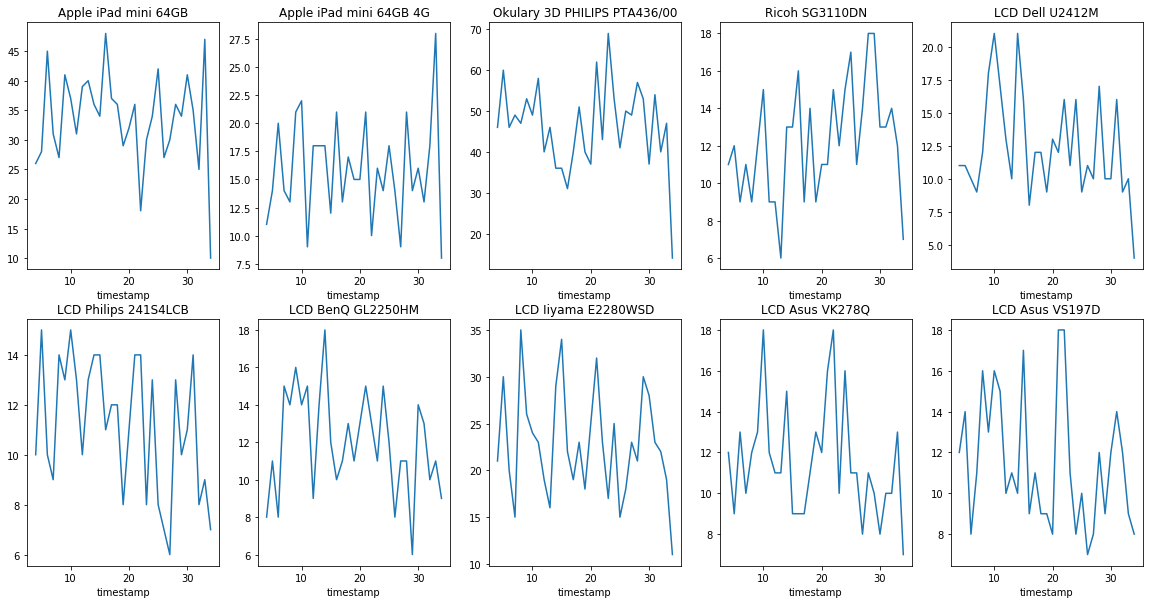

In [11]:
plot_timeseries(df_viewed, 'product_id', labels_column='product_name', n=10)

Z analizy popularności produktów w zależności od daty doszliśmy do wniosku, że nie ma żadnej korelacji między tymi dwoma wartościami. Z wykresów obrazujących te zależności można wywnioskować, że popularność produktów zawsze oscyluje wokół pewnej stałej wartości.

In [12]:
def get_corrcoef_for_column(df, column, n=100):
    cnt = df[column].value_counts()
    idx = cnt.head(n).index
    weeks = range(44)
    
    correlations = []
    
    for i in range(n):
        temp = df[df[column] == idx[i]]
        # ignore if some data is missing
        hours = temp['timestamp'].dt.day * 24 + temp['timestamp'].dt.hour
        hours = hours // 6
        gb = temp.groupby(hours)[column].count()
        array = [gb, hours.unique()]
        correlation = np.corrcoef(array)[1,0]
        print(correlation)
        correlations.append(correlation)
        
    print("\nMaximum correlation found: ", max(correlations))
    print("Minimum correlation found: ", min(correlations))


In [13]:
get_corrcoef_for_column(df_viewed, 'product_id')

-0.0697641216351447
-0.05774135392965743
-0.1525356112154691
-0.2166688312626205
-0.01920071475011363
0.007446415576630936
0.2067713761106262
0.07393659360695658
0.020579421322857217
-0.11914753927585725
0.03074408406944068
0.13301921637323008
-0.02545840027442851
0.18438684630098723
-0.1623867531479514
0.23777655313005974
-0.130783699567518
-0.3385028771794171
-0.014704783100148881
-0.36953670983919706
0.24099505636355106
-0.2405752151734502
-0.2539765999959859
-0.16576092456199645
-0.17754443275532367
-0.22441978168289012
-0.28796183713921625
-0.11455702654675153
0.18903024725953593
-0.017741144310298825
-0.29705233025392747
-0.13129230046516432
-0.1127459099552627
0.03395138791185586
0.1091499491101582
-0.19674267357041123
-0.5511205507893419
-0.08773993612534975
0.03220987706269332
0.03841862248520185
0.22043306452924272
-0.3024184130500724
0.10710358847213144
-0.12555359482478942
0.1305145862064032
0.04680323087168039
-0.06136522122969198
-0.465822448516117
-0.2825059311855704
0.0

Wyliczenie współczynnika korelacji dla produktów utwierdziło nas we wniosku, że dane nie są skorelowane. Nawet w najbardziej skrajnych przypadkach te korelacje są na tyle delikatne i jest ich tak mało, że wynikają bardziej z losowości. 

Unique values in "category_path": 15


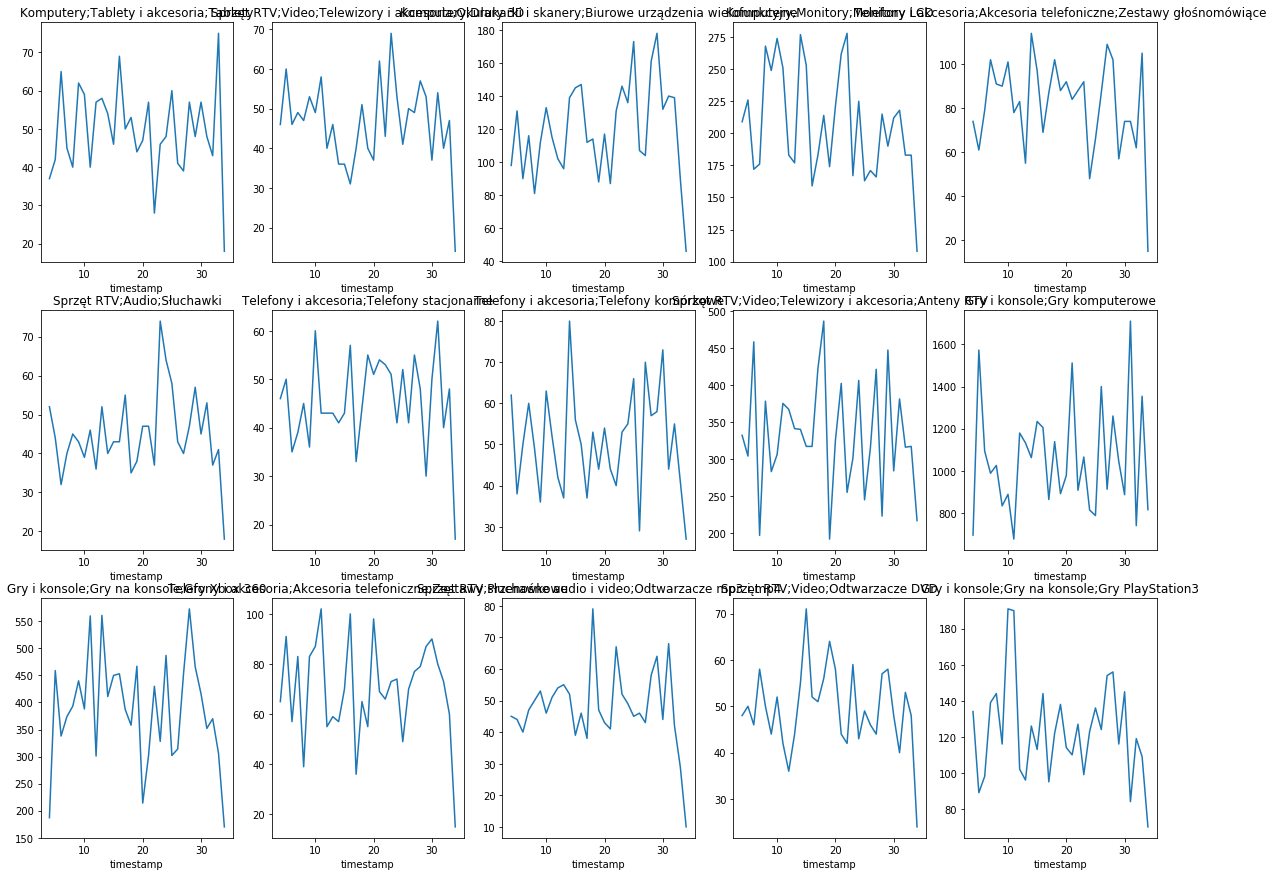

In [14]:
plot_timeseries(df_viewed, 'category_path', n=15)

In [15]:
len(df_viewed['category_path'].str.replace(';.*', '').unique())

4

Unique values in "category_path": 4


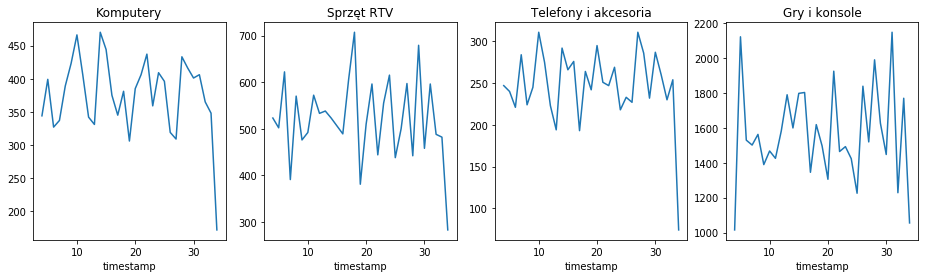

In [16]:
df_temp = df_viewed.copy()
df_temp['category_path'] = df_viewed['category_path'].str.replace(';.*', '')
plot_timeseries(df_temp, 'category_path', n=4)

In [17]:
print("Korelacje dla wszystkich kategorii:")
get_corrcoef_for_column(df_viewed, 'category_path', 15)

print("\n\n\n")

print("Korelacje dla ogólnych kategorii:")
get_corrcoef_for_column(df_temp, 'category_path', 4)

Korelacje dla wszystkich kategorii:
0.17496618607405004
-0.12533685286104676
-0.06943227146980581
-0.13714442806858393
-0.18596582850520685
0.019020779254935866
0.16423083771507488
-0.06586286515645763
0.041518054148610595
0.1236075774276935
-0.2510220204775511
0.18864356628618814
-0.0697641216351447
-0.05774135392965743
-0.1525356112154691

Maximum correlation found:  0.18864356628618814
Minimum correlation found:  -0.2510220204775511




Korelacje dla ogólnych kategorii:
0.4391864033403305
-0.23675877477316243
-0.23728381379059268
0.029398406954678925

Maximum correlation found:  0.4391864033403305
Minimum correlation found:  -0.23728381379059268


Dla kategorii przeprowadziliśmy analogiczną analizę jak dla pojedynczych produktów. Ponownie nie ma znaczących korelacji. **W związku z tym, że nie ma trendów związanych z datą, to pominiemy ją w naszym modelu.**

<h1>Analiza zniżek</h1>

In [18]:
df_viewed.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,100001,2021-01-08 11:35:40,102.0,1276,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
1,100001,2021-01-08 11:38:48,102.0,1277,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB 4G,Komputery;Tablety i akcesoria;Tablety,2317.02
2,100001,2021-01-08 11:40:32,102.0,1276,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
4,100002,2021-01-05 18:08:21,102.0,1283,VIEW_PRODUCT,0,NaN,Okulary 3D PHILIPS PTA436/00,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99
5,100002,2021-01-05 18:12:35,102.0,1283,VIEW_PRODUCT,0,NaN,Okulary 3D PHILIPS PTA436/00,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99


In [19]:
df_viewed.shape

(83919, 10)

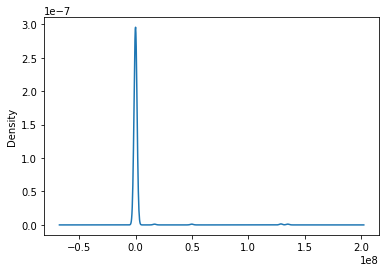

In [20]:
df_viewed['price'].plot.density()

Na potrzeby analizy zniżek usuwamy błędne ceny.

In [21]:
mask1 = df['price'] > 0
mask2 = df['price'] < 100_000

print('Cen ujemnych:', (~mask1).sum())
print('Cen za dużych:', (~mask2).sum())
print('W sumie usuwamy:', (~mask1).sum() + (~mask2).sum())
df = df[mask1 & mask2]

Cen ujemnych: 3409
Cen za dużych: 1809
W sumie usuwamy: 5218


Text(0, 0.5, 'mean price')

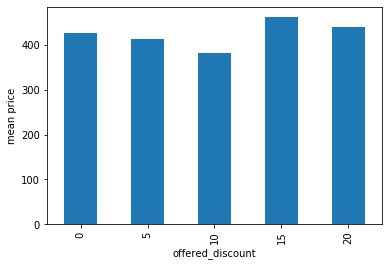

In [22]:
df.groupby('offered_discount')['price'].mean().plot(kind='bar')
plt.ylabel('mean price')

Jak widzimy cena produktu zakupionego przez klienta nie zależy od oferowanej mu zniżki. Nie jest więc tak, że klienci po dostaniu zniżki kupują droższe czy też tańsze produkty niż normalnie.

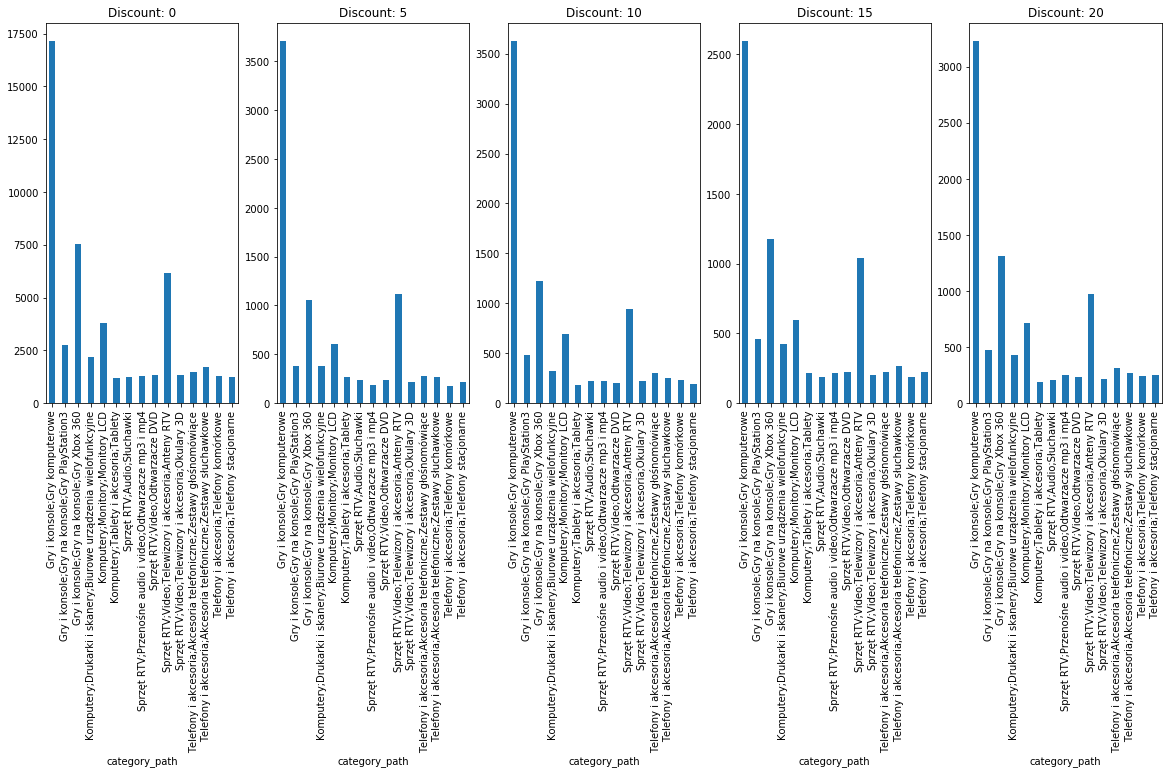

In [23]:
discounts = sorted(df['offered_discount'].unique())

plt.figure(figsize=(20, 7))
for i, discount in enumerate(discounts):
  plt.subplot(1, len(discounts), i+1)
  plt.title(f'Discount: {discount}')
  temp = df[df['offered_discount'] == discount]
  temp.groupby(['category_path'])['category_path'].count().plot(kind='bar')
plt.show()

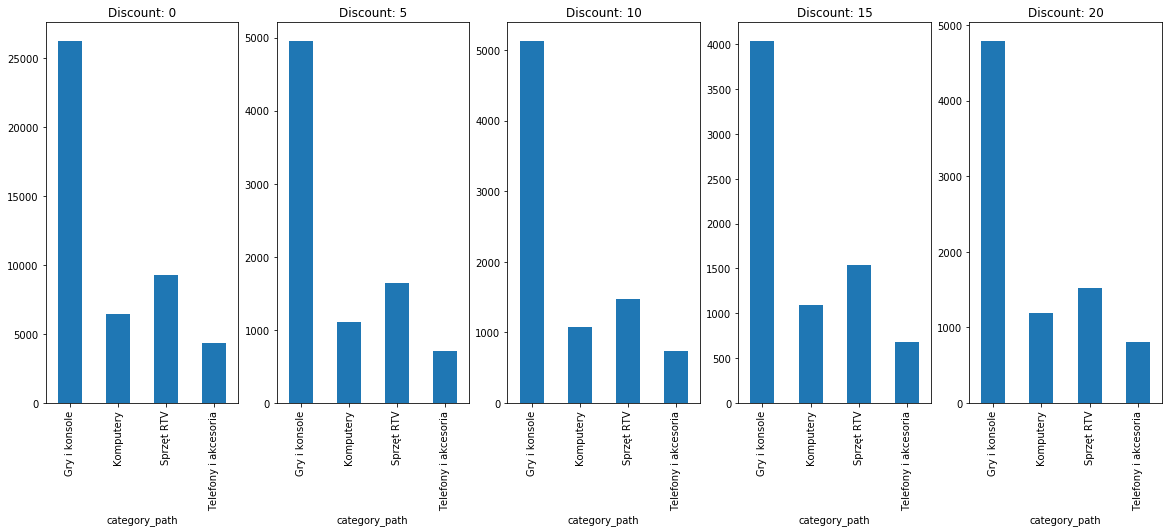

In [24]:
df_temp['category_path'] = df['category_path'].str.replace(';.*', '')
plt.figure(figsize=(20, 7))
for i, discount in enumerate(discounts):
  plt.subplot(1, len(discounts), i+1)
  plt.title(f'Discount: {discount}')
  temp = df_temp[df_temp['offered_discount'] == discount]
  temp.groupby(['category_path'])['category_path'].count().plot(kind='bar')
plt.show()

Wygląda na to, że fakt posiadania zniżki nie wpływa też na to, produkty której kategorii klienci kupują. **Ostatecznie stwierdzamy, że zniżka jest nieistotna i nie będziemy jej używać w naszym modelu**.

<h1>Analiza sesji</h1>

In [25]:
print('Liczba unikalnych sesji:', len(df_viewed['session_id'].unique()))

Liczba unikalnych sesji: 10778


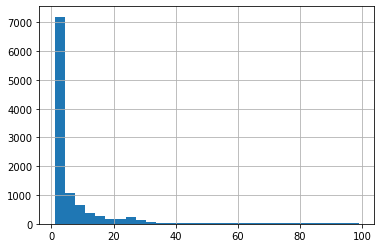

In [26]:
df_viewed.groupby('session_id')['session_id'].count().hist(bins=30)

In [27]:
df_viewed['category_path'].nunique() # dla upewnienia się

15

In [28]:
unique_categories = df_viewed.groupby('session_id')['category_path'].nunique()
unique_categories.max()

1

In [29]:
unique_products_count = df_viewed.groupby('session_id')['product_id'].nunique()
products_count = df_viewed.groupby('session_id')['product_id'].count()
print(unique_products_count.max(), products_count.max())

98 99


In [30]:
mask = df_viewed[['session_id', 'product_id']].duplicated(keep=False)
df_temp = df_viewed[mask]
df_temp.shape

(13634, 10)

In [31]:
df_temp.groupby('session_id')['product_id'].count().max() # there is at most 1 duplicate per session (not counting the duplicate from buying a product)

2

In [32]:
duplicated_products = sorted(df_temp['product_id'].unique()) # will be used later in items analysis

In [33]:
unique_products_count = df_bought.groupby('session_id')['product_id'].nunique()
products_count = df_bought.groupby('session_id')['product_id'].count()
print(unique_products_count.max(), products_count.max())

1 1


Zauważamy, że w każdej sesji jest przeglądany tylko jeden rodzaj produktów. Na podstawie tego jesteśmy w stanie potwierdzić naszą intuicję, że produkty przeglądane w ramach sesji nie są losowe tylko podobne do przeglądanych wcześniej produktów. 
<br>**Nasz model może zatem wykorzystywać informacje o aktualnej sesji do polecania kolejnych produktów wartych obejrzenia.**

<h1>Analiza użytkowników</h1>

Do dalszej analizy usuwamy rekordy z zakupami - zostawiamy tylko rekordy, gdzie produkt został obejrzany. Robimy to dlatego, że każdy produkt który został zakupiony został wcześniej obejrzany, a my chcemy uniknąć takich powtórek przy kolejnych analizach.

In [34]:
df_viewed.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,100001,2021-01-08 11:35:40,102.0,1276,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
1,100001,2021-01-08 11:38:48,102.0,1277,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB 4G,Komputery;Tablety i akcesoria;Tablety,2317.02
2,100001,2021-01-08 11:40:32,102.0,1276,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
4,100002,2021-01-05 18:08:21,102.0,1283,VIEW_PRODUCT,0,NaN,Okulary 3D PHILIPS PTA436/00,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99
5,100002,2021-01-05 18:12:35,102.0,1283,VIEW_PRODUCT,0,NaN,Okulary 3D PHILIPS PTA436/00,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99


In [35]:
def get_embeddings(users):
    embeddings = users.groupby(['user_id', 'category_path'])['category_path'].count().unstack(level=1)
    embeddings = embeddings.fillna(0.0)
    counts = embeddings.sum(axis=1)
    embeddings = embeddings.div(counts, axis=0)
    
    return embeddings, counts

In [36]:
users_embeddings, counts = get_embeddings(df_viewed)

In [37]:
idx = counts.argsort().iloc[::-1]

In [38]:
counts = counts.iloc[idx]
users_embeddings = users_embeddings.iloc[idx]

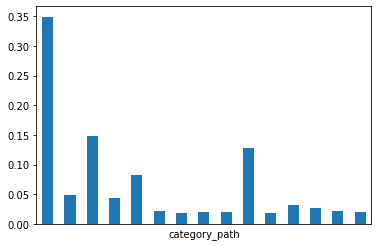

In [39]:
users_embeddings.mean(axis=0).plot(kind='bar', xticks=[])

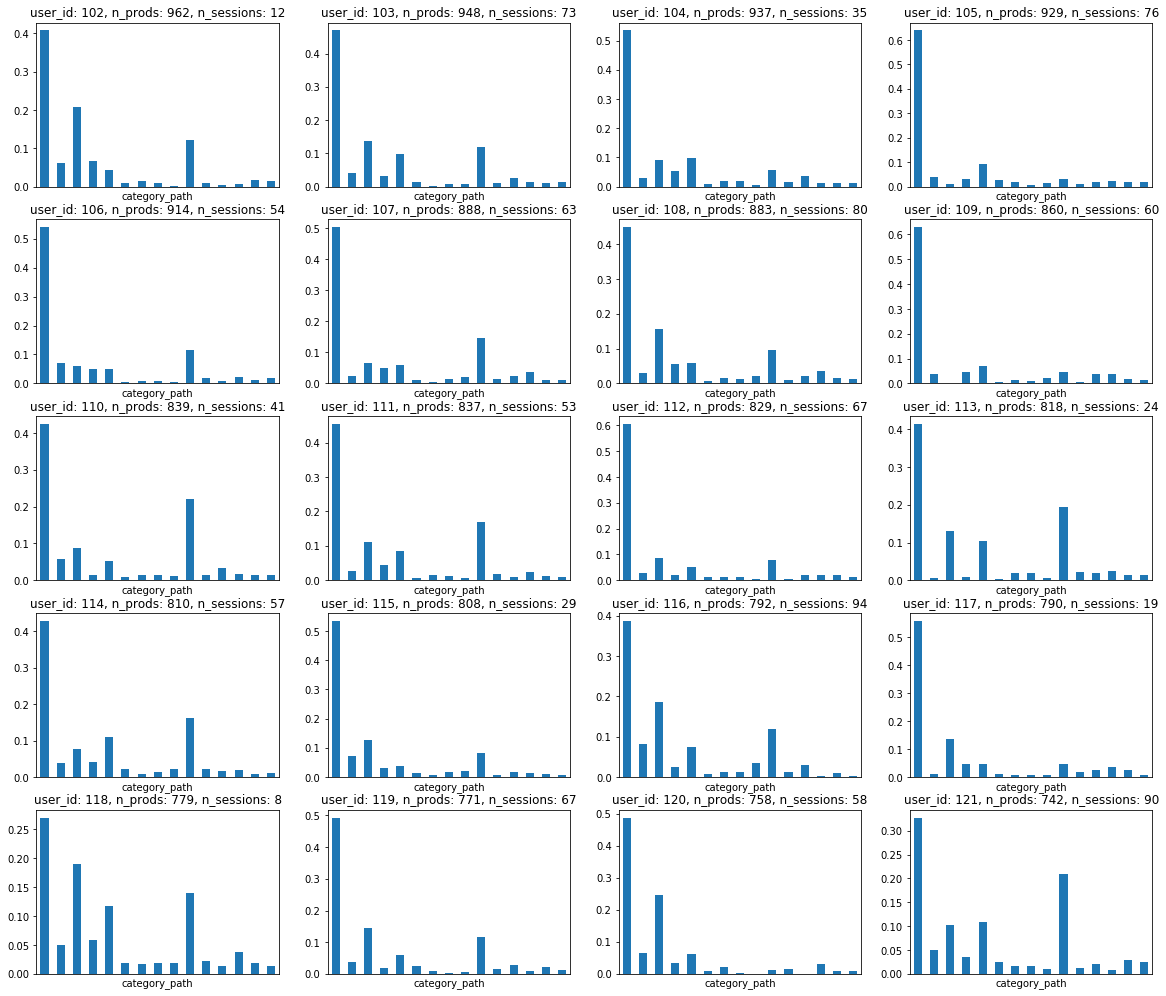

In [40]:
users = sorted(users_embeddings.index)
n_users = 20

plt.figure(figsize=(20, math.ceil(n_users / 4) * 3.5))
for i, user in enumerate(users[:n_users]):
    plt.subplot(math.ceil(n_users / 4), 4, i+1)
    n_sessions = len(df_viewed.loc[df_viewed['user_id'] == user, 'session_id'].unique())
    plt.title(f'user_id: {int(user)}, n_prods: {int(counts.iloc[i])}, n_sessions: {n_sessions}')
    users_embeddings.iloc[i].plot(kind='bar', xticks=[])
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.093441


C:\Users\Lasze\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:325: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.923164
[t-SNE] KL divergence after 300 iterations: 0.407647


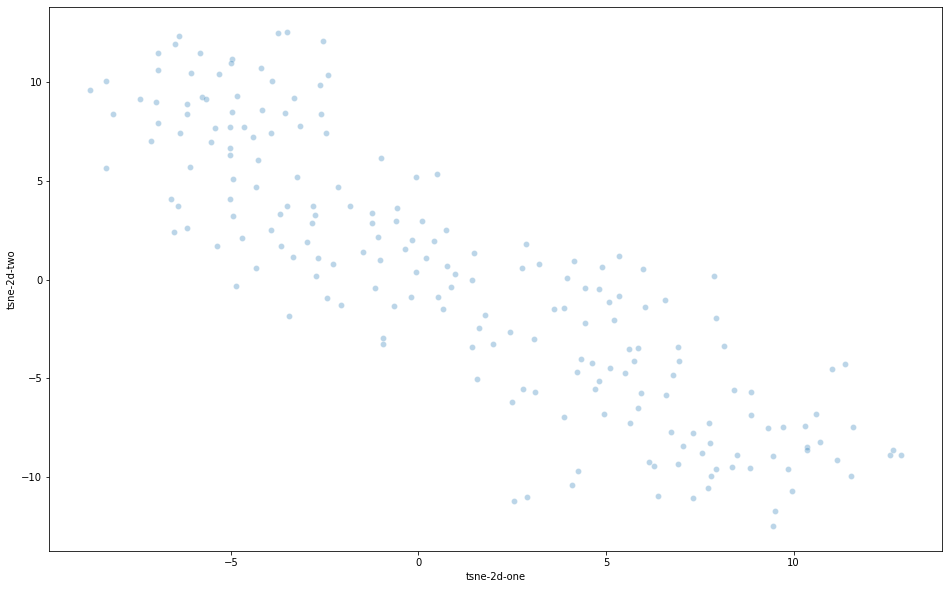

In [76]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(users_embeddings)

df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

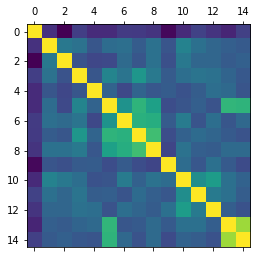

In [43]:
corr = users_embeddings.corr()
plt.matshow(corr)
plt.show()

In [44]:
corr.style.background_gradient(cmap='coolwarm')

category_path,Gry i konsole;Gry komputerowe,Gry i konsole;Gry na konsole;Gry PlayStation3,Gry i konsole;Gry na konsole;Gry Xbox 360,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,Komputery;Monitory;Monitory LCD,Komputery;Tablety i akcesoria;Tablety,Sprzęt RTV;Audio;Słuchawki,Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,Sprzęt RTV;Video;Odtwarzacze DVD,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe,Telefony i akcesoria;Telefony komórkowe,Telefony i akcesoria;Telefony stacjonarne
category_path,,,,,,,,,,,,,,,
Gry i konsole;Gry komputerowe,1.000000,-0.253070,-0.461976,-0.192551,-0.279655,-0.280426,-0.208442,-0.214920,-0.241542,-0.428195,-0.289624,-0.174479,-0.242616,-0.308414,-0.182701
Gry i konsole;Gry na konsole;Gry PlayStation3,-0.253070,1.000000,0.121223,0.086471,-0.072559,0.052450,0.071817,-0.035737,0.084029,-0.074436,0.188171,0.079059,0.022470,-0.020070,-0.047354
Gry i konsole;Gry na konsole;Gry Xbox 360,-0.461976,0.121223,1.000000,-0.085220,-0.151045,-0.140897,0.044310,-0.068461,0.081590,-0.102908,0.125349,0.019658,0.021553,-0.040594,-0.012325
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,-0.192551,0.086471,-0.085220,1.000000,-0.072655,0.199879,0.101498,0.308534,0.131265,-0.040626,0.064715,0.101207,0.082217,0.006546,-0.061569
Komputery;Monitory;Monitory LCD,-0.279655,-0.072559,-0.151045,-0.072655,1.000000,0.001944,-0.147236,0.007554,-0.062941,-0.034607,-0.091580,-0.031294,0.068980,0.035805,-0.077783
Komputery;Tablety i akcesoria;Tablety,-0.280426,0.052450,-0.140897,0.199879,0.001944,1.000000,0.284763,0.488831,0.368709,-0.116804,-0.078887,-0.021864,-0.086722,0.500262,0.488590
Sprzęt RTV;Audio;Słuchawki,-0.208442,0.071817,0.044310,0.101498,-0.147236,0.284763,1.000000,0.466556,0.447036,-0.042687,0.143755,-0.081582,0.065919,-0.068654,0.031189
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,-0.214920,-0.035737,-0.068461,0.308534,0.007554,0.488831,0.466556,1.000000,0.551790,-0.117310,-0.005260,0.046322,0.014993,-0.046998,-0.086295
Sprzęt RTV;Video;Odtwarzacze DVD,-0.241542,0.084029,0.081590,0.131265,-0.062941,0.368709,0.447036,0.551790,1.000000,-0.156809,0.087139,-0.018360,-0.033820,0.042306,0.041125


In [45]:
corr[corr!=1.0].max()

category_path
Gry i konsole;Gry komputerowe                                       -0.174479
Gry i konsole;Gry na konsole;Gry PlayStation3                        0.188171
Gry i konsole;Gry na konsole;Gry Xbox 360                            0.125349
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne       0.308534
Komputery;Monitory;Monitory LCD                                      0.068980
Komputery;Tablety i akcesoria;Tablety                                0.500262
Sprzęt RTV;Audio;Słuchawki                                           0.466556
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4             0.551790
Sprzęt RTV;Video;Odtwarzacze DVD                                     0.551790
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV                   0.077982
Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D                   0.346687
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące    0.255258
Telefony i akcesoria;Akcesoria telefoniczne;Zestaw

In [46]:
corr.min()

category_path
Gry i konsole;Gry komputerowe                                       -0.461976
Gry i konsole;Gry na konsole;Gry PlayStation3                       -0.253070
Gry i konsole;Gry na konsole;Gry Xbox 360                           -0.461976
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne      -0.192551
Komputery;Monitory;Monitory LCD                                     -0.279655
Komputery;Tablety i akcesoria;Tablety                               -0.280426
Sprzęt RTV;Audio;Słuchawki                                          -0.208442
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4            -0.214920
Sprzęt RTV;Video;Odtwarzacze DVD                                    -0.241542
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV                  -0.428195
Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D                  -0.289624
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące   -0.174479
Telefony i akcesoria;Akcesoria telefoniczne;Zestaw

Stwórzmy teraz syntetyczny dataset z użytkownikami w celu sprawdzenia, czy wybieranie losowo sesji da nam podobne korelacje, co te prawdziwe.

In [47]:
import random

def generate_users(n_users, df):
    users_sessions = df.groupby('user_id')['session_id'].nunique()
    sessions = df['session_id'].unique()

    generated_sessions = {'user_id': [], 'session_id': []}
    for i in range(n_users):
        idx = random.sample(list(sessions), users_sessions.iloc[i % len(users_sessions)])
        for index in idx:
            generated_sessions['user_id'].append(i)
            generated_sessions['session_id'].append(index)

    generated_sessions = pd.DataFrame(generated_sessions)
    
    df_gen = generated_sessions.set_index('session_id')
    
    df_gen = df.drop(columns='user_id').join(df_gen, on='session_id')
    return df_gen

In [48]:
# it can take up to a minute
gen_users = generate_users(len(users_embeddings) * 100, df) # * 100 to generate larger sample
gen_users_embeddings, _ = get_embeddings(gen_users) 

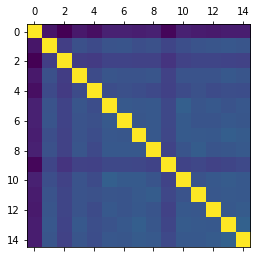

In [49]:
gen_corr = gen_users_embeddings.corr()
plt.matshow(gen_corr)
plt.show()

In [50]:
gen_corr.style.background_gradient(cmap='coolwarm')

category_path,Gry i konsole;Gry komputerowe,Gry i konsole;Gry na konsole;Gry PlayStation3,Gry i konsole;Gry na konsole;Gry Xbox 360,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,Komputery;Monitory;Monitory LCD,Komputery;Tablety i akcesoria;Tablety,Sprzęt RTV;Audio;Słuchawki,Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,Sprzęt RTV;Video;Odtwarzacze DVD,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe,Telefony i akcesoria;Telefony komórkowe,Telefony i akcesoria;Telefony stacjonarne
category_path,,,,,,,,,,,,,,,
Gry i konsole;Gry komputerowe,1.000000,-0.244982,-0.325765,-0.234901,-0.269540,-0.205812,-0.206576,-0.214478,-0.204429,-0.299874,-0.205828,-0.225463,-0.229362,-0.219460,-0.217848
Gry i konsole;Gry na konsole;Gry PlayStation3,-0.244982,1.000000,-0.080199,-0.000804,-0.025426,0.015269,0.019574,-0.006851,0.003441,-0.048662,-0.005569,0.015670,0.022755,0.036319,0.025069
Gry i konsole;Gry na konsole;Gry Xbox 360,-0.325765,-0.080199,1.000000,-0.084138,-0.094550,-0.060896,-0.058489,-0.066326,-0.066799,-0.127654,-0.061989,-0.048293,-0.049730,-0.058436,-0.063631
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,-0.234901,-0.000804,-0.084138,1.000000,-0.023862,0.023720,0.012797,0.015556,0.021819,-0.062744,0.014383,0.012260,0.011657,0.037380,0.022075
Komputery;Monitory;Monitory LCD,-0.269540,-0.025426,-0.094550,-0.023862,1.000000,-0.011854,-0.003563,-0.012770,-0.035637,-0.071432,-0.021043,0.004447,-0.024853,-0.009405,-0.014594
Komputery;Tablety i akcesoria;Tablety,-0.205812,0.015269,-0.060896,0.023720,-0.011854,1.000000,0.042200,0.033634,0.041415,-0.039622,0.074411,0.025264,0.040887,0.011566,0.033581
Sprzęt RTV;Audio;Słuchawki,-0.206576,0.019574,-0.058489,0.012797,-0.003563,0.042200,1.000000,0.027626,0.038527,-0.038498,0.048774,0.016951,0.021140,0.037748,0.030611
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,-0.214478,-0.006851,-0.066326,0.015556,-0.012770,0.033634,0.027626,1.000000,0.038392,-0.042400,0.047697,0.046237,0.037041,0.071924,0.056238
Sprzęt RTV;Video;Odtwarzacze DVD,-0.204429,0.003441,-0.066799,0.021819,-0.035637,0.041415,0.038527,0.038392,1.000000,-0.060997,0.017564,0.059083,0.019252,0.027274,0.045442


In [51]:
gen_corr[gen_corr!=1.0].max()

category_path
Gry i konsole;Gry komputerowe                                       -0.204429
Gry i konsole;Gry na konsole;Gry PlayStation3                        0.036319
Gry i konsole;Gry na konsole;Gry Xbox 360                           -0.048293
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne       0.037380
Komputery;Monitory;Monitory LCD                                      0.004447
Komputery;Tablety i akcesoria;Tablety                                0.074411
Sprzęt RTV;Audio;Słuchawki                                           0.048774
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4             0.071924
Sprzęt RTV;Video;Odtwarzacze DVD                                     0.059083
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV                  -0.035442
Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D                   0.074411
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące    0.059083
Telefony i akcesoria;Akcesoria telefoniczne;Zestaw

In [52]:
gen_corr.min()

category_path
Gry i konsole;Gry komputerowe                                       -0.325765
Gry i konsole;Gry na konsole;Gry PlayStation3                       -0.244982
Gry i konsole;Gry na konsole;Gry Xbox 360                           -0.325765
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne      -0.234901
Komputery;Monitory;Monitory LCD                                     -0.269540
Komputery;Tablety i akcesoria;Tablety                               -0.205812
Sprzęt RTV;Audio;Słuchawki                                          -0.206576
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4            -0.214478
Sprzęt RTV;Video;Odtwarzacze DVD                                    -0.204429
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV                  -0.299874
Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D                  -0.205828
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące   -0.225463
Telefony i akcesoria;Akcesoria telefoniczne;Zestaw

In [53]:
corr_diff = (gen_corr - corr).abs()
corr_diff.style.background_gradient(cmap='coolwarm')

category_path,Gry i konsole;Gry komputerowe,Gry i konsole;Gry na konsole;Gry PlayStation3,Gry i konsole;Gry na konsole;Gry Xbox 360,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,Komputery;Monitory;Monitory LCD,Komputery;Tablety i akcesoria;Tablety,Sprzęt RTV;Audio;Słuchawki,Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,Sprzęt RTV;Video;Odtwarzacze DVD,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe,Telefony i akcesoria;Telefony komórkowe,Telefony i akcesoria;Telefony stacjonarne
category_path,,,,,,,,,,,,,,,
Gry i konsole;Gry komputerowe,0.000000,0.008088,0.136211,0.042350,0.010115,0.074615,0.001867,0.000442,0.037113,0.128321,0.083796,0.050984,0.013254,0.088953,0.035146
Gry i konsole;Gry na konsole;Gry PlayStation3,0.008088,0.000000,0.201422,0.087275,0.047132,0.037181,0.052243,0.028886,0.080588,0.025774,0.193740,0.063389,0.000285,0.056389,0.072423
Gry i konsole;Gry na konsole;Gry Xbox 360,0.136211,0.201422,0.000000,0.001082,0.056495,0.080001,0.102799,0.002136,0.148389,0.024746,0.187338,0.067951,0.071283,0.017843,0.051306
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,0.042350,0.087275,0.001082,0.000000,0.048792,0.176159,0.088701,0.292978,0.109446,0.022118,0.050332,0.088947,0.070560,0.030834,0.083644
Komputery;Monitory;Monitory LCD,0.010115,0.047132,0.056495,0.048792,0.000000,0.013799,0.143673,0.020324,0.027304,0.036825,0.070537,0.035741,0.093833,0.045210,0.063189
Komputery;Tablety i akcesoria;Tablety,0.074615,0.037181,0.080001,0.176159,0.013799,0.000000,0.242563,0.455197,0.327295,0.077182,0.153298,0.047128,0.127609,0.488696,0.455009
Sprzęt RTV;Audio;Słuchawki,0.001867,0.052243,0.102799,0.088701,0.143673,0.242563,0.000000,0.438930,0.408508,0.004189,0.094982,0.098533,0.044780,0.106402,0.000578
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,0.000442,0.028886,0.002136,0.292978,0.020324,0.455197,0.438930,0.000000,0.513398,0.074910,0.052957,0.000085,0.022048,0.118922,0.142533
Sprzęt RTV;Video;Odtwarzacze DVD,0.037113,0.080588,0.148389,0.109446,0.027304,0.327295,0.408508,0.513398,0.000000,0.095812,0.069575,0.077443,0.053072,0.015032,0.004317


In [54]:
corr_diff_max = corr_diff.max().max()
corr_diff_max

0.6999678428675697

In [55]:
corr_diff_mean = corr_diff.mean().mean()
corr_diff_mean

0.09780280689485944

Wygenerujemy teraz embeddingi dla takiej samej ilości użytkowników, jaką mamy w dataset'cie. Dzięki temu sprawdzimy, czy różnice między naszymi korelacjami dla embeddingów prawdziwych użytkowników i tych wygenerowanych mogą być efektem losowości.

In [56]:
# it can take up to a minute

max_diffs = []
mean_diffs = []
unique_categories_counts = []
n_iterations = 100

for i in range(n_iterations):
    temp_users = generate_users(len(users_embeddings), df)
    temp_embeddings, _ = get_embeddings(temp_users)
    temp_corr = temp_embeddings.corr()
    temp_corr_diff = (gen_corr - temp_corr).abs()
    
    max_diff = temp_corr_diff.max().max()
    mean_diff = temp_corr_diff.mean().mean()
    max_diffs.append(max_diff)
    mean_diffs.append(mean_diff)
    
    temp_unique_categories_count = temp_users.groupby('user_id')['category_path'].nunique().mean()
    unique_categories_counts.append(temp_unique_categories_count)

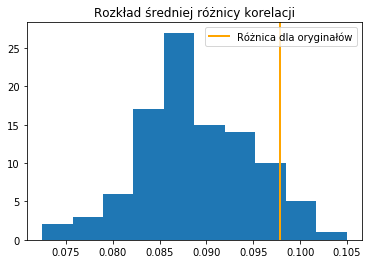

In [57]:
plt.hist(mean_diffs, bins=int(n_iterations ** 0.5))
plt.axvline(corr_diff_mean, color='orange', linewidth=2)
plt.title('Rozkład średniej różnicy korelacji')
plt.legend(['Różnica dla oryginałów'])
plt.show()

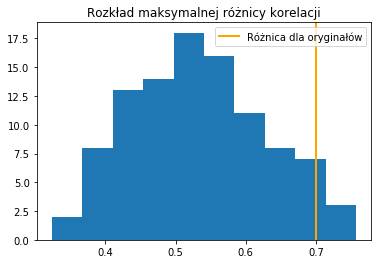

In [58]:
plt.hist(max_diffs, bins=int(n_iterations ** 0.5))
plt.axvline(corr_diff_max, color='orange', linewidth=2)
plt.title('Rozkład maksymalnej różnicy korelacji')
plt.legend(['Różnica dla oryginałów'])
plt.show()

In [59]:
original_categories_counts = df.groupby('user_id')['category_path'].nunique().mean()
original_categories_counts

13.24

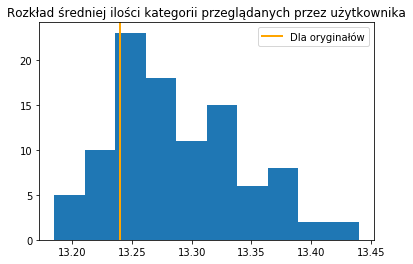

In [60]:
plt.hist(unique_categories_counts, bins=int(n_iterations ** 0.5))
plt.axvline(original_categories_counts, color='orange', linewidth=2)
plt.title('Rozkład średniej ilości kategorii przeglądanych przez użytkownika')
plt.legend(['Dla oryginałów'])
plt.show()

Jak widać korelacje dla prawdziwych użytkowników niewiele różnią się od korelacji dla wygenerowanych użytkowników - można uznać, że różnica ta jest spowodowana losowością. Z tego wynika, wbrew naszym oczekiwaniom, że użytkownicy nie mają żadnych preferencji co do kategorii produktów, które oglądają. Możemy uznać więc, że historia użytkownika nie dostarcza nam żadnych nowych informacji, a system polecania warto robić używając jedynie historii aktualnej sesji.

<h1>Analiza rozkładów przedmiotów</h1>

In [61]:
df.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,100001,2021-01-08 11:35:40,102.0,1276,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
1,100001,2021-01-08 11:38:48,102.0,1277,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB 4G,Komputery;Tablety i akcesoria;Tablety,2317.02
2,100001,2021-01-08 11:40:32,102.0,1276,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
3,100001,2021-01-08 11:40:57,102.0,1276,BUY_PRODUCT,15,20001.0,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
4,100002,2021-01-05 18:08:21,102.0,1283,VIEW_PRODUCT,0,NaN,Okulary 3D PHILIPS PTA436/00,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99


In [62]:
print(duplicated_products)

[1001, 1008, 1032, 1035, 1043, 1055, 1079, 1222, 1234, 1276, 1281, 1283, 1285, 1317, 1318]


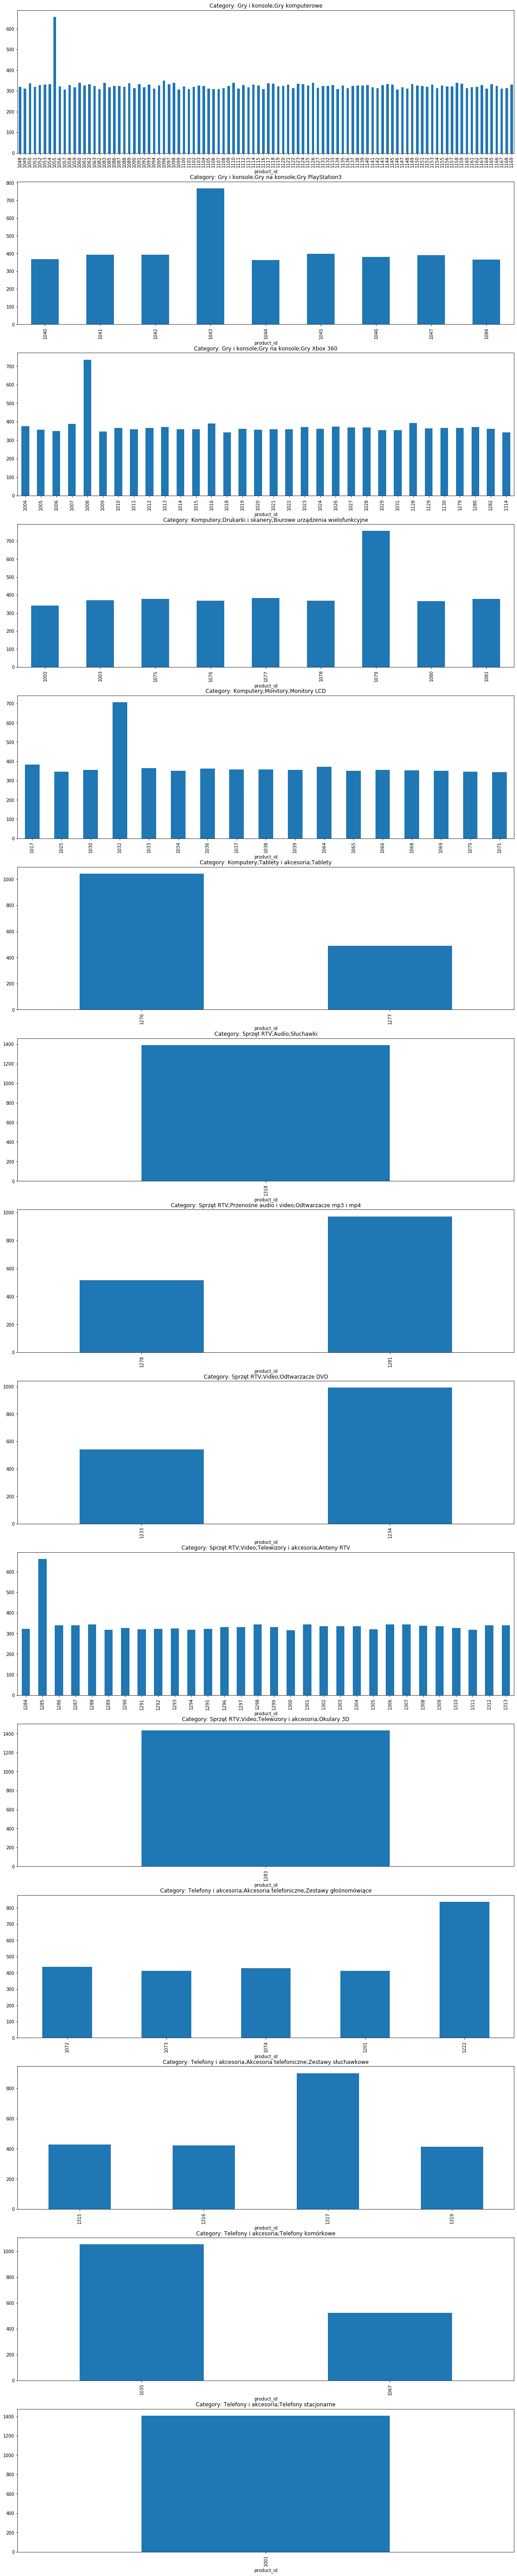

In [63]:
categories = sorted(df_viewed['category_path'].unique())

plt.figure(figsize=(20, len(categories) * 7))
for i, category in enumerate(categories):
    plt.subplot(len(categories), 1, i+1)
    plt.title(f'Category: {category}')
    temp = df_viewed[df_viewed['category_path'] == category]
    temp.groupby(['product_id'])['product_id'].count().plot(kind='bar')
    temp_gb = temp.groupby(['product_id'])['product_id'].count()
    temp_gb.plot(kind='bar')
    assert(int(temp_gb.idxmax()) in duplicated_products) # checking if the most viewed product is always the same as the one being duplicated
plt.show()

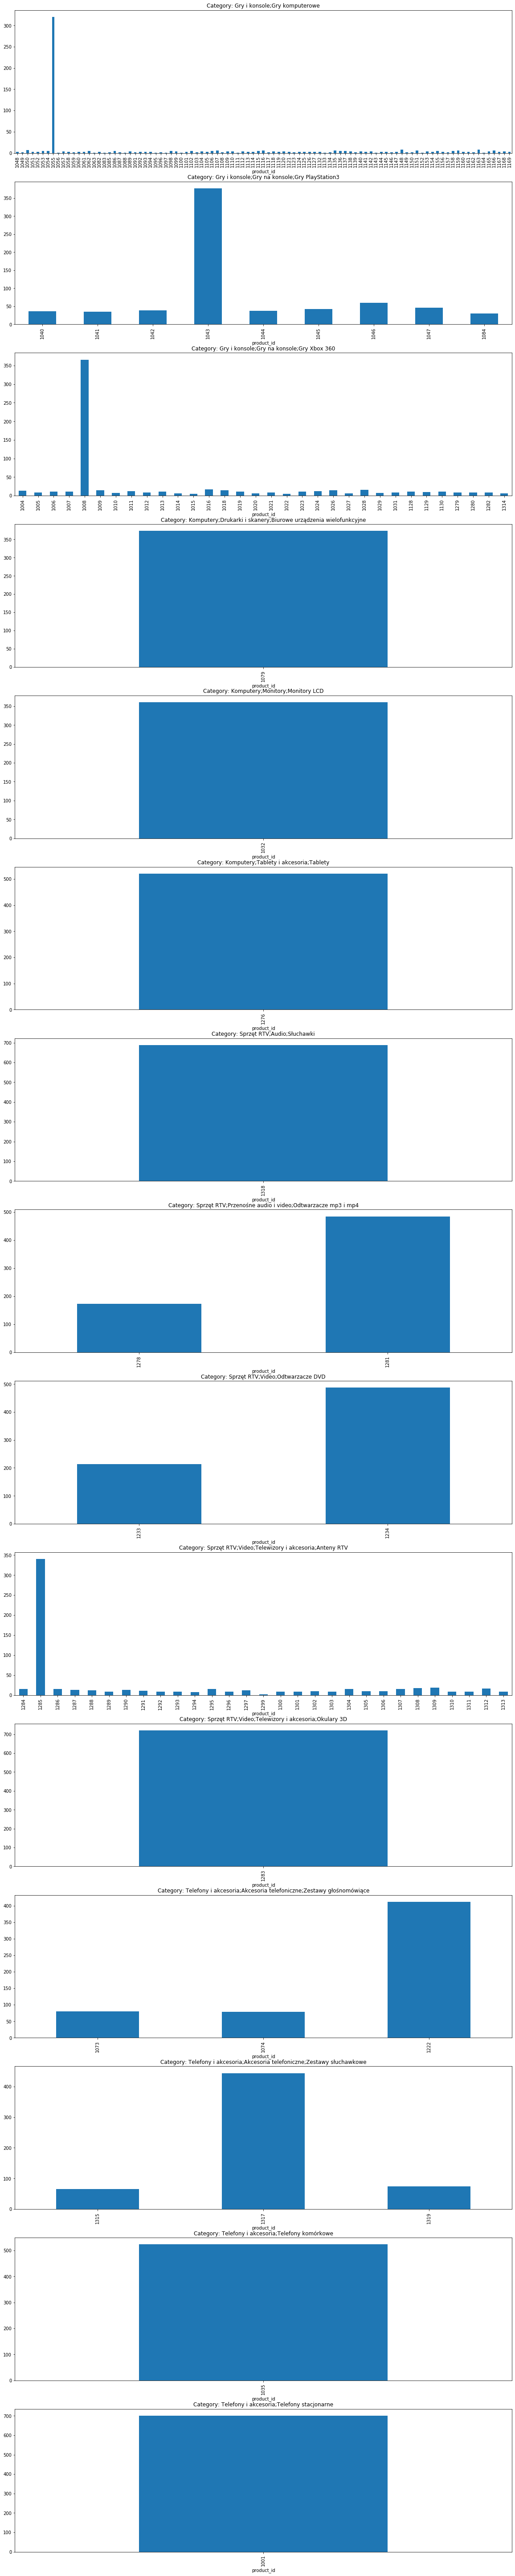

In [64]:
categories = sorted(df_bought['category_path'].unique())

plt.figure(figsize=(20, len(categories) * 7))
for i, category in enumerate(categories):
    plt.subplot(len(categories), 1, i+1)
    plt.title(f'Category: {category}')
    temp = df_bought[df_bought['category_path'] == category]
    temp_gb = temp.groupby(['product_id'])['product_id'].count()
    temp_gb.plot(kind='bar')
    assert(temp_gb.idxmax() in duplicated_products) # checking if the most bought product is always the same as the one being duplicated
plt.show()

In [70]:
df_bought.groupby(['user_id', 'product_id'])['product_id'].count()

user_id  product_id
102.0    1001          2
         1032          1
         1035          1
         1222          1
         1276          1
                      ..
301.0    1309          1
         1313          1
         1317          4
         1318          1
         1319          2
Name: product_id, Length: 4040, dtype: int64